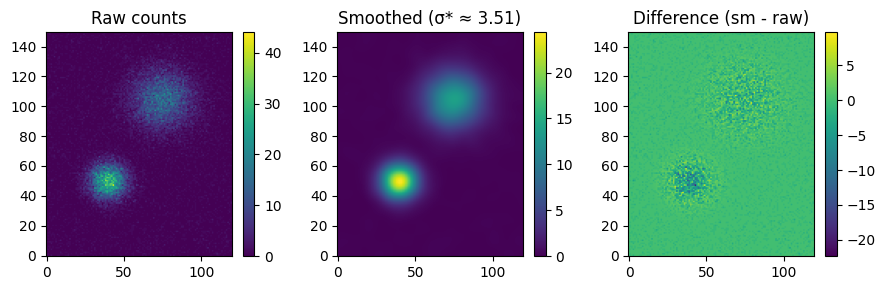

In [2]:
# Auto-Poisson 2D smoothing with zero manual parameters
# Method: Anscombe variance-stabilizing transform (Poisson->~Gaussian w/ σ≈1),
# choose Gaussian blur σ by minimizing Stein’s Unbiased Risk Estimate (SURE),
# then invert the transform with the Makitalo–Foi (2011) unbiased inverse.
#
# Usage:
#   H_smoothed = smooth2d_auto(H)  # H is a 2D array of nonnegative counts
#
# Demo at the bottom on synthetic data.

import numpy as np
from scipy.ndimage import gaussian_filter
import math

def anscombe(x):
    """Anscombe VST: y = 2*sqrt(x + 3/8) for x>=0."""
    x = np.asarray(x, dtype=np.float64)
    return 2.0 * np.sqrt(np.clip(x, 0, None) + 3.0/8.0)

def inv_anscombe_unbiased(y):
    """
    Unbiased inverse for the Anscombe transform (Makitalo & Foi, 2011, 2013 approximation).
    Valid for y>0; returns >=0.
    """
    y = np.asarray(y, dtype=np.float64)
    # Avoid divide-by-zero
    eps = 1e-12
    z = np.maximum(y, eps)
    # Polynomial expansion (Eq. (5) in Makitalo & Foi 2011)
    z2 = z*z
    z3 = z2*z
    z4 = z2*z2
    term = (z/2.0)**2 - 1.0/8.0 + 1.0/(4.0*np.sqrt(2.0)*z) - 11.0/(8.0*z2) + 5.0/(8.0*np.sqrt(2.0)*z3) - 1.0/(8.0*z4)
    return np.clip(term, 0, None)

def _gaussian_center_weight(sigma, radius=6):
    """
    Compute the central coefficient (trace contribution per pixel) of a normalized
    discrete 2D Gaussian kernel with standard deviation `sigma`, using a finite window.
    This is used in the SURE trace term for a linear, shift-invariant filter.
    """
    if sigma <= 0:
        return 1.0  # identity (no blur) -> center weight 1
    r = max(1, int(radius * sigma))
    ax = np.arange(-r, r+1, dtype=np.float64)
    g1d = np.exp(-0.5 * (ax / sigma)**2)
    g1d /= g1d.sum()
    # 2D separable kernel; center weight = g1d[center]^2
    center = r
    return float(g1d[center] * g1d[center])

def _sure_for_sigma(y, sigma, center_weight):
    """
    SURE for linear Gaussian smoothing in the VST domain where noise variance≈1.
    SURE(σ) = -N*σ_n^2 + ||Ky - y||^2 + 2*σ_n^2 * trace(K)
    with σ_n^2≈1 after Anscombe; trace(K) = N * center_weight.
    """
    if sigma <= 0:
        Ky = y  # identity
    else:
        Ky = gaussian_filter(y, sigma=sigma, mode="reflect")
    resid = Ky - y
    N = y.size
    # σ_n^2 ≈ 1 for Anscombe-stabilized Poisson
    return float(-N + np.sum(resid*resid) + 2.0 * N * center_weight)

def smooth2d_auto(H, sigma_grid=None):
    """
    Poisson-aware, parameter-free smoothing of a 2D histogram of counts.
    - H: 2D array of nonnegative integers/floats (counts)
    - sigma_grid: optional iterable of candidate Gaussian sigmas; if None, picked automatically.
    Returns a float64 array with the smoothed expected counts (same shape as H).
    """
    H = np.asarray(H, dtype=np.float64)
    if H.ndim != 2:
        raise ValueError("H must be a 2D array of counts.")
    # 1) VST
    Y = anscombe(H)
    # 2) Pick candidate σ values based on data scale
    if sigma_grid is None:
        # Characteristic size: min dimension; search σ in [0, 5] with denser sampling near 0
        # Include 0 for "no blur" baseline; log-spaced positive values thereafter.
        pos = np.geomspace(0.25, 5.0, 18)  # adjust density as needed
        sigma_grid = np.concatenate([[0.0], pos])
    # 3) Evaluate SURE(σ); for efficiency, precompute center weights
    best_sigma = None
    best_sure = np.inf
    best_Ky = None
    # Precompute center weights per sigma
    center_weights = {float(s): _gaussian_center_weight(float(s)) for s in sigma_grid}
    for s in sigma_grid:
        s = float(s)
        # Compute Ky once for the best candidate
        Ky = Y if s == 0.0 else gaussian_filter(Y, sigma=s, mode="reflect")
        sure = -Y.size + np.sum((Ky - Y)**2) + 2.0 * Y.size * center_weights[s]
        if sure < best_sure:
            best_sure = sure
            best_sigma = s
            best_Ky = Ky
    # 4) Invert VST back to counts
    est_counts = inv_anscombe_unbiased(best_Ky)
    return est_counts, best_sigma, best_sure

# -------------------------------
# Demo on synthetic data:
if __name__ == "__main__":
    import matplotlib.pyplot as plt
    
    # Synthetic "true" intensity: two Gaussians on a 2D grid
    rng = np.random.default_rng(42)
    nx, ny = 150, 120
    x = np.linspace(-3, 3, nx)
    y = np.linspace(-2.4, 2.4, ny)
    X, Yg = np.meshgrid(x, y, indexing="ij")
    truth = 30*np.exp(-((X+1.0)**2 + (Yg+0.8)**2)/(2*0.3**2)) + 15*np.exp(-((X-1.2)**2 + (Yg-0.6)**2)/(2*0.5**2)) + 0.3
    # Poisson draw to mimic a 2D histogram of counts
    H = rng.poisson(truth)
    
    H_sm, sigma_opt, sure_val = smooth2d_auto(H)
    
    # Plot: raw counts vs smoothed estimate
    fig1 = plt.figure(figsize=(9, 3))
    plt.subplot(1,3,1)
    plt.title("Raw counts")
    plt.imshow(H, origin="lower", aspect="auto")
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title(f"Smoothed (σ* ≈ {sigma_opt:.2f})")
    plt.imshow(H_sm, origin="lower", aspect="auto")
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title("Difference (sm - raw)")
    plt.imshow(H_sm - H, origin="lower", aspect="auto")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [3]:
H

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 2, ..., 1, 0, 1]])